# Preprocessing, Modelling and Evaluation

In [1]:
# data science essentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for audio
import IPython.display as ipd
import librosa
import librosa.display

# modelling and preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten, Masking, GRU, LSTM
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.utils import to_categorical

# for processing images for CNN
import os
from PIL import Image

# for timing code
import time


Using TensorFlow backend.


In [2]:
train_df = pd.read_csv("datasets/train.csv")

In [3]:
train_df.head()

,id,filepath,duration,class_label
0,10210049,./assets/audio_train/10210049_father.wav,0.457959,father
1,10210049,./assets/audio_train/10210049_worker.wav,0.519501,worker
2,10210051,./assets/audio_train/10210051_water.wav,0.395828,water
3,10210062,./assets/audio_train/10210062_flowers.wav,0.399229,flowers
4,10210066,./assets/audio_train/10210066_apples.wav,0.524354,apples


In [4]:
train_df.shape

(1049, 4)

## 3. Preprocessing

There are many ways of preprocessing audio files and the methods of preprocessing is heavily dependent on the type of classification model which will be used.

The model I will be building is:

1. Feedforward Neural Network ( 2 kind of preprocessing )
2. Convolutional Neural Network
3. Recurrent Neural Network with LSTM
4. Ensemble Method

### Preprocessing for Feedforward Neural Network (FNN)

**Calculate the Mean and Standard Deviation of MFCC and the Delta**

Getting the Mean and Standard Deviation is a way of normalising the data since they are all of different shape.

In [5]:
def get_mfccs_features(file_list, n_mfcc=40):
    """
    This function will take in a list of audio file path and return a dictionary of 4 MFCC features.
    The 4 features will be transformed from a shape of (ts, 40) to (1, 40), where "ts" is the number of timesteps.
    The first feature is the mean of the MFCC across time.
    The second feature is the standard deviation of MFCC across time.
    The third feature is the mean of the delta of the MFCC across time.
    The fourth feature is the standard deviation of the MFCC across time.
    
    The dictionary can be used to add into the dataframe later
    
    """
    
    # set up empty list and dictionary
    features = {}
    
    mean = []
    std = []
    delta_mean = []
    delta_std = []
    
    for f in file_list:
        audio, sr = librosa.load(f) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
        mfccs_delta = librosa.feature.delta(mfccs)
        
        # mfcc mean across time
        mfccs_mean = np.mean(mfccs.T,axis=0)
        mean.append(mfccs_mean)
        
        # mfcc standard deviation across time
        mfccs_std = np.std(mfccs.T,axis=0)
        std.append(mfccs_std)
        
        # mean of mfcc delta across time
        mfccs_delta_mean = np.mean(mfccs_delta.T,axis=0)
        delta_mean.append(mfccs_delta_mean)
        
        # standard deviation of mfcc delta across time
        mfccs_delta_std = np.std(mfccs_delta.T,axis=0)
        delta_std.append(mfccs_delta_std)
    
    # add all of the list into the empty dictionary
    features['mfccs_mean'] = mean
    features['mfccs_std'] = std
    features['mfccs_delta_mean'] = delta_mean
    features['mfccs_delta_std'] = delta_std
    
    return features

In [6]:
# get all the features

mfccs_features = get_mfccs_features(train_df['filepath'])

# add them into the dataframe
for k, v in mfccs_features.items():
    train_df[k] = v

In [7]:
# check if done correctly
train_df.head(3)

,id,filepath,duration,class_label,mfccs_mean,mfccs_std,mfccs_delta_mean,mfccs_delta_std
0,10210049,./assets/audio_train/10210049_father.wav,0.457959,father,"[-196.65865, 126.91008, -32.876976, 25.416832,...","[58.43318, 37.41045, 29.724075, 16.595234, 13....","[7.6438293, 2.0495448, -2.2808201, 0.26232308,...","[12.530376, 8.677294, 7.3228106, 4.123108, 2.8..."
1,10210049,./assets/audio_train/10210049_worker.wav,0.519501,worker,"[-258.90433, 171.56952, 5.8856416, 34.963104, ...","[62.08626, 30.751865, 25.998608, 21.70042, 16....","[-4.5402517, -3.4924977, -0.37305757, -0.64102...","[10.262612, 6.768381, 4.2443323, 5.0021243, 2...."
2,10210051,./assets/audio_train/10210051_water.wav,0.395828,water,"[-235.71283, 148.99991, 7.0049567, 34.56189, -...","[87.36377, 34.059155, 39.78111, 24.895144, 33....","[3.2932093, -4.0986385, -3.06783, 1.4283211, 2...","[11.529502, 5.509337, 4.7498536, 5.5789504, 6...."


**Create a Combined Feature Column**

Another feature that can be created is the combination of all the 4 features, giving us an array shape of (160, 1). This would give each training data more features to distinguish itself.

In [8]:
# create a new feature with a dimension of 160, stacking the mean and standard deviation of 
# the mfcc and its delta.

combined_features = []
for n in range(0,len(train_df)):
    combined_features.append(np.concatenate((train_df['mfccs_mean'][n],
                                             train_df['mfccs_std'][n], 
                                             train_df['mfccs_delta_mean'][n],
                                             train_df['mfccs_delta_std'][n])))
    
train_df['combined_mfccs'] = combined_features
# this will give us an array of (160, 1)

In [9]:
# check if done correctly
train_df.head(3)

,id,filepath,duration,class_label,mfccs_mean,mfccs_std,mfccs_delta_mean,mfccs_delta_std,combined_mfccs
0,10210049,./assets/audio_train/10210049_father.wav,0.457959,father,"[-196.65865, 126.91008, -32.876976, 25.416832,...","[58.43318, 37.41045, 29.724075, 16.595234, 13....","[7.6438293, 2.0495448, -2.2808201, 0.26232308,...","[12.530376, 8.677294, 7.3228106, 4.123108, 2.8...","[-196.65865, 126.91008, -32.876976, 25.416832,..."
1,10210049,./assets/audio_train/10210049_worker.wav,0.519501,worker,"[-258.90433, 171.56952, 5.8856416, 34.963104, ...","[62.08626, 30.751865, 25.998608, 21.70042, 16....","[-4.5402517, -3.4924977, -0.37305757, -0.64102...","[10.262612, 6.768381, 4.2443323, 5.0021243, 2....","[-258.90433, 171.56952, 5.8856416, 34.963104, ..."
2,10210051,./assets/audio_train/10210051_water.wav,0.395828,water,"[-235.71283, 148.99991, 7.0049567, 34.56189, -...","[87.36377, 34.059155, 39.78111, 24.895144, 33....","[3.2932093, -4.0986385, -3.06783, 1.4283211, 2...","[11.529502, 5.509337, 4.7498536, 5.5789504, 6....","[-235.71283, 148.99991, 7.0049567, 34.56189, -..."


### Preprocessing for Recurrent Neural Network (RNN)

The RNN takes in sequential data and this would mean that we do not have to compress the array like how it was done for FNN. In order to ensure they have the same shape, it will also be padded with zeroes. During the fitting, the zeroes will be masked so that the model knows the padding should be disregarded.

**Extract Raw MFCC Array and Raw MFCC Delta & Delta2 Array**

The function below also needs to transpose the array because for sequential data, the input shape should be (ts, n_mfcc) where `ts` represents timesteps while `n_mfcc` represents number of MFCC coefficient. For our case, `ts` will be padded to the maximum timestep present in the entire dataset while the `n_mfcc` will be 40.

In [10]:
def get_mfcc(file, n_mfcc=40):
    """
    Gets the MFCC array, and transposes it.
    """
    audio, sr = librosa.load(file) 
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfccs.T

In [11]:
def get_mfcc_combined(file, n_mfcc=40):
    """
    extracts the mfcc, the delta and delta2 across timestep and return a transposed concatenation.
    """
    
    audio, sr = librosa.load(file) 
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    delta = librosa.feature.delta(mfccs)
    delta2 = librosa.feature.delta(mfccs, order = 2)
    combined = np.concatenate((mfccs, delta, delta2))
    return combined.T

In [12]:
# apply function to all files
mfcc_all = train_df['filepath'].map(get_mfcc)

# padding
mfcc_all = pad_sequences(mfcc_all, padding='post')

# add into the dataframe
train_df['mfcc_pad'] = mfcc_all.tolist()

In [13]:
# apply function to all files
mfcc_combined = train_df['filepath'].map(get_mfcc_combined)

# padding
mfcc_combined = pad_sequences(mfcc_combined, padding='post')

# add into dataframe
train_df['mfcc_pad_combined'] = mfcc_combined.tolist()

In [14]:
# check if all correctly done

train_df.head()

,id,filepath,duration,class_label,mfccs_mean,mfccs_std,mfccs_delta_mean,mfccs_delta_std,combined_mfccs,mfcc_pad,mfcc_pad_combined
0,10210049,./assets/audio_train/10210049_father.wav,0.457959,father,"[-196.65865, 126.91008, -32.876976, 25.416832,...","[58.43318, 37.41045, 29.724075, 16.595234, 13....","[7.6438293, 2.0495448, -2.2808201, 0.26232308,...","[12.530376, 8.677294, 7.3228106, 4.123108, 2.8...","[-196.65865, 126.91008, -32.876976, 25.416832,...","[[-292, 70, -6, 39, -23, 24, -24, 18, -19, 0, ...","[[-292, 70, -6, 39, -23, 24, -24, 18, -19, 0, ..."
1,10210049,./assets/audio_train/10210049_worker.wav,0.519501,worker,"[-258.90433, 171.56952, 5.8856416, 34.963104, ...","[62.08626, 30.751865, 25.998608, 21.70042, 16....","[-4.5402517, -3.4924977, -0.37305757, -0.64102...","[10.262612, 6.768381, 4.2443323, 5.0021243, 2....","[-258.90433, 171.56952, 5.8856416, 34.963104, ...","[[-362, 188, 46, -1, -12, -11, 0, -10, -19, -6...","[[-362, 188, 46, -1, -12, -11, 0, -10, -19, -6..."
2,10210051,./assets/audio_train/10210051_water.wav,0.395828,water,"[-235.71283, 148.99991, 7.0049567, 34.56189, -...","[87.36377, 34.059155, 39.78111, 24.895144, 33....","[3.2932093, -4.0986385, -3.06783, 1.4283211, 2...","[11.529502, 5.509337, 4.7498536, 5.5789504, 6....","[-235.71283, 148.99991, 7.0049567, 34.56189, -...","[[-316, 165, 42, 39, 0, -1, -9, -2, -12, -20, ...","[[-316, 165, 42, 39, 0, -1, -9, -2, -12, -20, ..."
3,10210062,./assets/audio_train/10210062_flowers.wav,0.399229,flowers,"[-233.44008, 127.30211, 11.549065, 42.032394, ...","[44.99465, 60.81429, 18.286491, 29.394094, 21....","[-0.2987371, -4.79065, 2.8436575, 3.4281251, -...","[9.446445, 16.08716, 2.7725258, 6.156691, 4.67...","[-233.44008, 127.30211, 11.549065, 42.032394, ...","[[-300, 81, 2, 22, -39, 18, -24, 18, -5, 4, 11...","[[-300, 81, 2, 22, -39, 18, -24, 18, -5, 4, 11..."
4,10210066,./assets/audio_train/10210066_apples.wav,0.524354,apples,"[-242.86156, 123.218254, -12.731119, 54.86693,...","[71.841354, 71.481544, 38.154087, 27.27552, 38...","[-5.2192245, -10.501004, 5.264592, 1.5651596, ...","[14.663708, 11.573661, 4.3268127, 5.169234, 5....","[-242.86156, 123.218254, -12.731119, 54.86693,...","[[-285, 126, -45, 51, -1, -55, -29, -12, -6, -...","[[-285, 126, -45, 51, -1, -55, -29, -12, -6, -..."


**Preprocessing For CNN**

From the EDA, it seems possible to do a classification based on Spectrogram. This section does two forms of preprocessing. The first type transforms the audio file into plotting data for the mel-spectrogram. This plotting data will also be used for one CNN model.

The second type transforms the audio file into a mel-spectrogram and then saving it as a PNG file. It will be then be subsequently used to train another CNN model.

In [15]:
def get_mel(filename):
    """
    This function gives the melspectrogram array and padded to a fixed dimension.
    """
    audio, sr = librosa.load(filename)
    mel= librosa.feature.melspectrogram(audio, sr=sr, n_mels=20)
    mel = librosa.util.fix_length(mel,45)
    return mel

In [16]:
# apply the mel-spectrogram function to all the files

train_df['mel'] = train_df['filepath'].map(get_mel)

In [17]:
# check if successful
train_df.head(3)

,id,filepath,duration,class_label,mfccs_mean,mfccs_std,mfccs_delta_mean,mfccs_delta_std,combined_mfccs,mfcc_pad,mfcc_pad_combined,mel
0,10210049,./assets/audio_train/10210049_father.wav,0.457959,father,"[-196.65865, 126.91008, -32.876976, 25.416832,...","[58.43318, 37.41045, 29.724075, 16.595234, 13....","[7.6438293, 2.0495448, -2.2808201, 0.26232308,...","[12.530376, 8.677294, 7.3228106, 4.123108, 2.8...","[-196.65865, 126.91008, -32.876976, 25.416832,...","[[-292, 70, -6, 39, -23, 24, -24, 18, -19, 0, ...","[[-292, 70, -6, 39, -23, 24, -24, 18, -19, 0, ...","[[0.09585485, 0.03155937, 0.00384897, 0.377477..."
1,10210049,./assets/audio_train/10210049_worker.wav,0.519501,worker,"[-258.90433, 171.56952, 5.8856416, 34.963104, ...","[62.08626, 30.751865, 25.998608, 21.70042, 16....","[-4.5402517, -3.4924977, -0.37305757, -0.64102...","[10.262612, 6.768381, 4.2443323, 5.0021243, 2....","[-258.90433, 171.56952, 5.8856416, 34.963104, ...","[[-362, 188, 46, -1, -12, -11, 0, -10, -19, -6...","[[-362, 188, 46, -1, -12, -11, 0, -10, -19, -6...","[[1.5918645, 21.006813, 87.20263, 143.3757, 15..."
2,10210051,./assets/audio_train/10210051_water.wav,0.395828,water,"[-235.71283, 148.99991, 7.0049567, 34.56189, -...","[87.36377, 34.059155, 39.78111, 24.895144, 33....","[3.2932093, -4.0986385, -3.06783, 1.4283211, 2...","[11.529502, 5.509337, 4.7498536, 5.5789504, 6....","[-235.71283, 148.99991, 7.0049567, 34.56189, -...","[[-316, 165, 42, 39, 0, -1, -9, -2, -12, -20, ...","[[-316, 165, 42, 39, 0, -1, -9, -2, -12, -20, ...","[[3.2332034, 8.094086, 16.798113, 23.049984, 3..."


**Save Spectrograms as PNG**

In [18]:
# generate spectrogram for each file

# for each file
for n, f in enumerate(train_df['filepath']):
    
    # get unique id
    audio_id = train_df['id'][n]
    
    # get label
    label = train_df['class_label'][n]
    
    # load file
    audio, sr = librosa.load(f)
    
    # plot spectrogram
    plt.figure(figsize=[2,2])
    mel_spec = librosa.feature.melspectrogram(audio, sr=sr, n_mels=20)
    log_mel_spec = librosa.power_to_db(mel_spec)
    librosa.display.specshow(log_mel_spec)
    
    # save and close, slightly padded
    plt.savefig(f"./assets/spec_train/{label}_{audio_id}.png", dpi=500, bbox_inches='tight',pad_inches=0.1)
    plt.close()


In [19]:
# create training data

img_size = 300

# target folder
folder = "./assets/spec_train/"

# create empty list for spectrogram data and label
train_data_spec = []
train_label_spec = []

# get image data and label
for img in os.listdir(folder):
    label, filename = img.split('_')
    path = os.path.join(folder, img)
    im = Image.open(path)
    im = im.convert('RGB')
    im = im.resize((img_size, img_size), Image.ANTIALIAS)
    train_data_spec.append(np.array(im))
    train_label_spec.append(label)


# normalise the data
train_data_spec = np.array(train_data_spec)/255

In [20]:
# create the y label for cnn
le_cnn = LabelEncoder()
y_cnn = to_categorical(le_cnn.fit_transform(train_label_spec))
y_cnn = np.array(y_cnn)

## 4. Modelling

The types of model which will be built are:

1. Feedforward Neural Network (FNN)
2. Convolutional Neural Network (CNN)
3. Recurrent Neural Network
    - Long-Short Term Memory (LSTM)
    - Gated Recurrent Units (GRUC)

In [21]:
# set random seed
np.random.seed(42)

from tensorflow import random
random.set_seed(42)

**Model 1: Feedforward Neural Network (baseline model)**

- Features: MFCC Mean
- Input Shape: (40,1)

The most basic neural network is trained based on the MFCC mean of each coefficient across the whole time frame, turning it all into a single dimension, most suitable for a vanilla neural network.

The accuracy will also be used as the baseline score.

In [22]:
X = train_df['mfccs_mean']

In [23]:
X = np.array(X.tolist())

In [24]:
# one-hot encoding of the classes
le = LabelEncoder()
y = to_categorical(le.fit_transform(train_df['class_label'].tolist()))
y = np.array(y)

In [25]:
X_train_1, X_test_1, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [26]:
model_1 = Sequential()

# two dense layer
model_1.add(Dense(64, activation='relu', input_shape=(40,)))
model_1.add(Dense(64, activation='relu'))

# output layer
model_1.add(Dense(5, activation='softmax'))

In [27]:
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [28]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                2624      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 7,109
Trainable params: 7,109
Non-trainable params: 0
_________________________________________________________________


In [29]:
%%time

history = model_1.fit(X_train_1, y_train, validation_data=(X_test_1, y_test), batch_size=32, epochs = 50, verbose=2)

Train on 839 samples, validate on 210 samples
Epoch 1/50
 - 0s - loss: 7.4926 - accuracy: 0.2324 - val_loss: 2.9196 - val_accuracy: 0.3571
Epoch 2/50
 - 0s - loss: 2.3258 - accuracy: 0.4100 - val_loss: 2.0743 - val_accuracy: 0.4524
Epoch 3/50
 - 0s - loss: 1.5496 - accuracy: 0.5411 - val_loss: 1.8274 - val_accuracy: 0.5048
Epoch 4/50
 - 0s - loss: 1.2559 - accuracy: 0.5816 - val_loss: 1.4492 - val_accuracy: 0.5762
Epoch 5/50
 - 0s - loss: 0.9904 - accuracy: 0.6675 - val_loss: 1.4173 - val_accuracy: 0.6048
Epoch 6/50
 - 0s - loss: 0.9053 - accuracy: 0.6722 - val_loss: 1.4595 - val_accuracy: 0.6143
Epoch 7/50
 - 0s - loss: 0.8882 - accuracy: 0.6782 - val_loss: 1.3024 - val_accuracy: 0.6286
Epoch 8/50
 - 0s - loss: 0.7849 - accuracy: 0.7294 - val_loss: 1.2389 - val_accuracy: 0.6143
Epoch 9/50
 - 0s - loss: 0.7304 - accuracy: 0.7426 - val_loss: 1.3268 - val_accuracy: 0.6190
Epoch 10/50
 - 0s - loss: 0.7839 - accuracy: 0.7330 - val_loss: 1.3516 - val_accuracy: 0.6286
Epoch 11/50
 - 0s - los

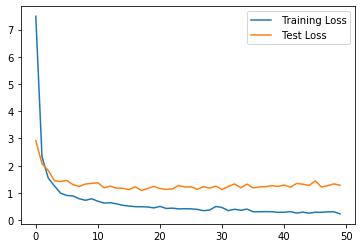

In [30]:
plt.plot(history.history['loss'], label = ' Training Loss')
plt.plot(history.history['val_loss'], label = ' Test Loss')
plt.legend()

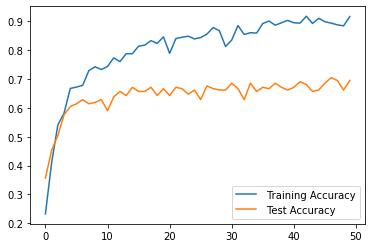

In [31]:
plt.plot(history.history['accuracy'], label = ' Training Accuracy')
plt.plot(history.history['val_accuracy'], label = ' Test Accuracy')
plt.legend()

In [32]:
# print evaluation score

model_1_eval = model_1.evaluate(X_test_1,y_test, verbose=1)
model_1_metrics = model_1.metrics_names

print(f"Model 1 {model_1_metrics[0]}: {model_1_eval[0]}")
print(f"Model 1 {model_1_metrics[1]}: {model_1_eval[1]}")

210/210 [==============================] - 0s 43us/step
Model 1 loss: 1.280540961310977
Model 1 accuracy: 0.6952381134033203


**Establish Baseline Score**

The baseline score is 69.5% accuracy. Subsequent models should outperform this vanilla neural network.

**Model 2: Feedforward Neural Network**

- Features: 40 MFCC x 4 indicators (mean and std, delta mean, delta std)
- Input Shape: (160,1) 

In [33]:
X = np.array(train_df['combined_mfccs'].tolist())

In [34]:
X_train_2, X_test_2, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [35]:
ss = StandardScaler()
X_train_2 = ss.fit_transform(X_train_2)
X_test_2 = ss.transform(X_test_2)

In [36]:
model_2 = Sequential()

# two dense layer
model_2.add(Dense(64, activation='relu', input_shape=(160,)))
model_2.add(Dense(64, activation='relu'))

# output layer
model_2.add(Dense(5, activation='softmax'))

In [37]:
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [38]:
%%time
history = model_2.fit(X_train_2, y_train, validation_data=(X_test_2, y_test), batch_size=32, epochs = 50, verbose=2)

Train on 839 samples, validate on 210 samples
Epoch 1/50
 - 0s - loss: 1.3003 - accuracy: 0.5089 - val_loss: 0.8984 - val_accuracy: 0.7714
Epoch 2/50
 - 0s - loss: 0.6121 - accuracy: 0.8558 - val_loss: 0.4634 - val_accuracy: 0.8952
Epoch 3/50
 - 0s - loss: 0.2852 - accuracy: 0.9511 - val_loss: 0.2670 - val_accuracy: 0.9429
Epoch 4/50
 - 0s - loss: 0.1460 - accuracy: 0.9809 - val_loss: 0.1954 - val_accuracy: 0.9524
Epoch 5/50
 - 0s - loss: 0.0843 - accuracy: 0.9893 - val_loss: 0.1583 - val_accuracy: 0.9524
Epoch 6/50
 - 0s - loss: 0.0520 - accuracy: 0.9976 - val_loss: 0.1426 - val_accuracy: 0.9524
Epoch 7/50
 - 0s - loss: 0.0345 - accuracy: 1.0000 - val_loss: 0.1322 - val_accuracy: 0.9524
Epoch 8/50
 - 0s - loss: 0.0257 - accuracy: 1.0000 - val_loss: 0.1253 - val_accuracy: 0.9476
Epoch 9/50
 - 0s - loss: 0.0181 - accuracy: 1.0000 - val_loss: 0.1223 - val_accuracy: 0.9524
Epoch 10/50
 - 0s - loss: 0.0136 - accuracy: 1.0000 - val_loss: 0.1184 - val_accuracy: 0.9524
Epoch 11/50
 - 0s - los

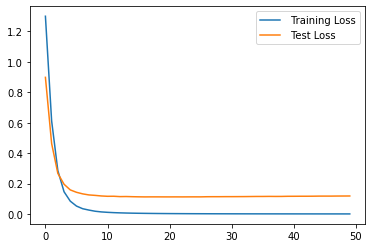

In [39]:
plt.plot(history.history['loss'], label = ' Training Loss')
plt.plot(history.history['val_loss'], label = ' Test Loss')
plt.legend()

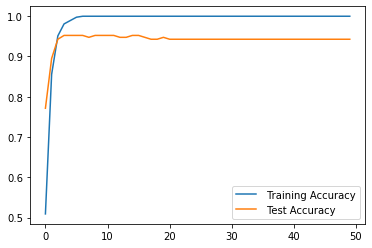

In [40]:
plt.plot(history.history['accuracy'], label = ' Training Accuracy')
plt.plot(history.history['val_accuracy'], label = ' Test Accuracy')
plt.legend()

In [41]:
# print evaluation score

model_2_eval = model_2.evaluate(X_test_2,y_test, verbose=1)
model_2_metrics = model_2.metrics_names

print(f"Model 2 {model_2_metrics[0]}: {model_2_eval[0]}")
print(f"Model 2 {model_2_metrics[1]}: {model_2_eval[1]}")

210/210 [==============================] - 0s 38us/step
Model 2 loss: 0.1183346152305603
Model 2 accuracy: 0.9428571462631226


**Model 3: Feedforward Neural Network**

- Features: timesteps x (40 MFCC x 3 features (MFCC, Delta, Delta2))
- Input Shape: (42, 120)

In [42]:
X = np.array(train_df['mfcc_pad_combined'].tolist())

In [43]:
# reshape for the model
X = X.reshape((1049, 42, 120))

In [44]:
X_train_3, X_test_3, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [45]:
model_3 = Sequential()

# two dense layers
model_3.add(Dense(128, activation='relu', input_shape=(42,120,)))
model_3.add(Dense(128, activation='relu'))

# flatten for the output layer
model_3.add(Flatten())

# output layer
model_3.add(Dense(5, activation='softmax'))

In [46]:
model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [47]:
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 42, 128)           15488     
_________________________________________________________________
dense_8 (Dense)              (None, 42, 128)           16512     
_________________________________________________________________
flatten_1 (Flatten)          (None, 5376)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 26885     
Total params: 58,885
Trainable params: 58,885
Non-trainable params: 0
_________________________________________________________________


In [48]:
%%time

history = model_3.fit(X_train_3, y_train, validation_data=(X_test_3, y_test), batch_size=32, epochs = 50, verbose=2)

Train on 839 samples, validate on 210 samples
Epoch 1/50
 - 0s - loss: 3.5624 - accuracy: 0.6746 - val_loss: 0.6937 - val_accuracy: 0.8857
Epoch 2/50
 - 0s - loss: 0.2455 - accuracy: 0.9452 - val_loss: 0.5676 - val_accuracy: 0.9381
Epoch 3/50
 - 0s - loss: 0.0832 - accuracy: 0.9762 - val_loss: 0.2286 - val_accuracy: 0.9571
Epoch 4/50
 - 0s - loss: 0.0309 - accuracy: 0.9917 - val_loss: 0.2113 - val_accuracy: 0.9524
Epoch 5/50
 - 0s - loss: 0.0098 - accuracy: 0.9988 - val_loss: 0.1979 - val_accuracy: 0.9476
Epoch 6/50
 - 0s - loss: 0.0021 - accuracy: 0.9988 - val_loss: 0.1875 - val_accuracy: 0.9571
Epoch 7/50
 - 0s - loss: 8.6746e-04 - accuracy: 1.0000 - val_loss: 0.1667 - val_accuracy: 0.9667
Epoch 8/50
 - 0s - loss: 2.8045e-04 - accuracy: 1.0000 - val_loss: 0.1632 - val_accuracy: 0.9667
Epoch 9/50
 - 0s - loss: 2.1988e-04 - accuracy: 1.0000 - val_loss: 0.1643 - val_accuracy: 0.9619
Epoch 10/50
 - 0s - loss: 1.8997e-04 - accuracy: 1.0000 - val_loss: 0.1639 - val_accuracy: 0.9619
Epoch 1

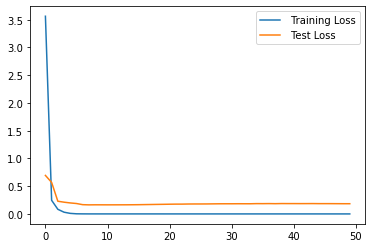

In [49]:
plt.plot(history.history['loss'], label = ' Training Loss')
plt.plot(history.history['val_loss'], label = ' Test Loss')
plt.legend()

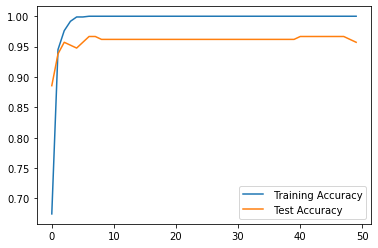

In [50]:
plt.plot(history.history['accuracy'], label = ' Training Accuracy')
plt.plot(history.history['val_accuracy'], label = ' Test Accuracy')
plt.legend()

In [51]:
# print evaluation score

model_3_eval = model_3.evaluate(X_test_3,y_test, verbose=1)
model_3_metrics = model_3.metrics_names

print(f"Model 3 {model_3_metrics[0]}: {model_3_eval[0]}")
print(f"Model 3 {model_3_metrics[1]}: {model_3_eval[1]}")

210/210 [==============================] - 0s 57us/step
Model 3 loss: 0.18385831749155407
Model 3 accuracy: 0.9571428298950195


**Model 4: Convolutional Neural Network (2D)**

- Features: mel-spectrogram array, padded until 45 sequence
- Input shape: (20, 45)

In [52]:
X = np.array(train_df['mel'].tolist())

In [53]:
X_train_4, X_test_4, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [54]:
# reshape for input layer as CNN takes in 3 dimensions

X_train_4 = X_train_4.reshape(X_train_4.shape[0], 20, 45, 1)
X_test_4 = X_test_4.reshape(X_test_4.shape[0], 20, 45, 1)

In [55]:
model_4 = Sequential()

# two 2D convolution layers
model_4.add(Conv2D(filters = 6, kernel_size=3, activation = 'relu', input_shape = (20,45,1), padding = 'same'))
model_4.add(MaxPooling2D(pool_size= (2,2), padding='same'))
model_4.add(Conv2D(32, kernel_size=3, activation='relu'))
model_4.add(MaxPooling2D(pool_size=(2,2), padding='same'))

# flatten for dense layer
model_4.add(Flatten())

# two dense layers
model_4.add(Dense(64, activation = 'relu'))
model_4.add(Dense(32, activation = 'relu'))

# output layer
model_4.add(Dense(5, activation = 'softmax'))

In [56]:
model_4.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [57]:
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 45, 6)         60        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 23, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 21, 32)         1760      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 11, 32)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1408)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                90176     
_________________________________________________________________
dense_11 (Dense)             (None, 32)               

In [58]:
%%time
history = model_4.fit(X_train_4,
                        y_train,
                        batch_size=32,
                        validation_data=(X_test_4, y_test),
                        epochs=100,
                        verbose=2)

Train on 839 samples, validate on 210 samples
Epoch 1/100
 - 1s - loss: 1.9398 - accuracy: 0.4839 - val_loss: 1.1071 - val_accuracy: 0.6190
Epoch 2/100
 - 0s - loss: 0.9374 - accuracy: 0.6770 - val_loss: 0.9453 - val_accuracy: 0.6857
Epoch 3/100
 - 0s - loss: 0.7062 - accuracy: 0.7533 - val_loss: 0.8311 - val_accuracy: 0.7048
Epoch 4/100
 - 0s - loss: 0.5630 - accuracy: 0.7974 - val_loss: 0.6990 - val_accuracy: 0.7619
Epoch 5/100
 - 0s - loss: 0.4722 - accuracy: 0.8367 - val_loss: 0.8037 - val_accuracy: 0.7000
Epoch 6/100
 - 0s - loss: 0.5020 - accuracy: 0.8319 - val_loss: 0.6646 - val_accuracy: 0.7524
Epoch 7/100
 - 0s - loss: 0.3647 - accuracy: 0.8701 - val_loss: 0.6353 - val_accuracy: 0.7667
Epoch 8/100
 - 0s - loss: 0.2658 - accuracy: 0.9178 - val_loss: 0.5141 - val_accuracy: 0.8381
Epoch 9/100
 - 0s - loss: 0.2305 - accuracy: 0.9213 - val_loss: 0.5379 - val_accuracy: 0.8095
Epoch 10/100
 - 0s - loss: 0.1841 - accuracy: 0.9547 - val_loss: 0.5464 - val_accuracy: 0.8333
Epoch 11/100


Epoch 86/100
 - 0s - loss: 3.5960e-04 - accuracy: 1.0000 - val_loss: 0.5848 - val_accuracy: 0.9000
Epoch 87/100
 - 0s - loss: 3.4424e-04 - accuracy: 1.0000 - val_loss: 0.5880 - val_accuracy: 0.9048
Epoch 88/100
 - 0s - loss: 3.4006e-04 - accuracy: 1.0000 - val_loss: 0.5906 - val_accuracy: 0.9000
Epoch 89/100
 - 0s - loss: 3.2754e-04 - accuracy: 1.0000 - val_loss: 0.5882 - val_accuracy: 0.9095
Epoch 90/100
 - 0s - loss: 3.1638e-04 - accuracy: 1.0000 - val_loss: 0.5904 - val_accuracy: 0.9048
Epoch 91/100
 - 0s - loss: 3.1579e-04 - accuracy: 1.0000 - val_loss: 0.5902 - val_accuracy: 0.9048
Epoch 92/100
 - 0s - loss: 3.0360e-04 - accuracy: 1.0000 - val_loss: 0.5940 - val_accuracy: 0.9000
Epoch 93/100
 - 0s - loss: 2.9202e-04 - accuracy: 1.0000 - val_loss: 0.5936 - val_accuracy: 0.9000
Epoch 94/100
 - 0s - loss: 2.8182e-04 - accuracy: 1.0000 - val_loss: 0.5937 - val_accuracy: 0.9048
Epoch 95/100
 - 0s - loss: 2.8814e-04 - accuracy: 1.0000 - val_loss: 0.5992 - val_accuracy: 0.9143
Epoch 96/1

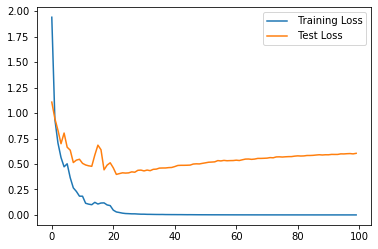

In [59]:
plt.plot(history.history['loss'], label = ' Training Loss')
plt.plot(history.history['val_loss'], label = ' Test Loss')
plt.legend()

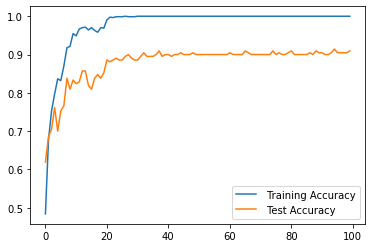

In [60]:
plt.plot(history.history['accuracy'], label = ' Training Accuracy')
plt.plot(history.history['val_accuracy'], label = ' Test Accuracy')
plt.legend()

In [61]:
# print evaluation scores
model_4_eval = model_4.evaluate(X_test_4, y_test, verbose=1)
model_4_metrics = model_4.metrics_names


print(f"Model 4 {model_4_metrics[0]}: {model_4_eval[0]}")
print(f"Model 4 {model_4_metrics[1]}: {model_4_eval[1]}")

210/210 [==============================] - 0s 52us/step
Model 4 loss: 0.6045355734371004
Model 4 accuracy: 0.9095237851142883


**Model 5: Convolutional Neural Network**

- Features: Mel-Spectrogram Images
- Input Shape (300, 300, 3)

In [62]:
X = train_data_spec

In [63]:
X_train_5, X_test_5, y_train_cnn, y_test_cnn = train_test_split(X, y_cnn, stratify = y_cnn, test_size= 0.2, random_state = 42)

In [64]:
model_5 = Sequential()

# 3 convolution layers
model_5.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(300,300,3)))
model_5.add(MaxPooling2D(pool_size=(2, 2)))

model_5.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))
model_5.add(Dropout(0.5))

model_5.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))
model_5.add(Dropout(0.5))

model_5.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model_5.add(MaxPooling2D(pool_size=(2, 2)))
model_5.add(Dropout(0.5))

# flatten for dense layer
model_5.add(Flatten())

# two dense layers
model_5.add(Dense(512, activation='relu'))
model_5.add(Dropout(0.5))

model_5.add(Dense(128, activation='relu'))
model_5.add(Dropout(0.5))

# output layer
model_5.add(Dense(5, activation='softmax'))

In [65]:
model_5.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [66]:
%%time

# set random seed
np.random.seed(42)

random.set_seed(42)

history = model_5.fit(X_train_5, y_train_cnn, validation_data=(X_test_5, y_test_cnn), batch_size=32, epochs = 100, verbose=2)

Train on 839 samples, validate on 210 samples
Epoch 1/100
 - 6s - loss: 1.8839 - accuracy: 0.1919 - val_loss: 1.6095 - val_accuracy: 0.2000
Epoch 2/100
 - 4s - loss: 1.5750 - accuracy: 0.2431 - val_loss: 1.4143 - val_accuracy: 0.5714
Epoch 3/100
 - 4s - loss: 1.1896 - accuracy: 0.5173 - val_loss: 0.8186 - val_accuracy: 0.8619
Epoch 4/100
 - 4s - loss: 0.7080 - accuracy: 0.7247 - val_loss: 0.4675 - val_accuracy: 0.9238
Epoch 5/100
 - 4s - loss: 0.4328 - accuracy: 0.8462 - val_loss: 0.2687 - val_accuracy: 0.9333
Epoch 6/100
 - 4s - loss: 0.3567 - accuracy: 0.8939 - val_loss: 0.1758 - val_accuracy: 0.9381
Epoch 7/100
 - 4s - loss: 0.2706 - accuracy: 0.9118 - val_loss: 0.1449 - val_accuracy: 0.9524
Epoch 8/100
 - 4s - loss: 0.2793 - accuracy: 0.9023 - val_loss: 0.1250 - val_accuracy: 0.9619
Epoch 9/100
 - 4s - loss: 0.2336 - accuracy: 0.9166 - val_loss: 0.1071 - val_accuracy: 0.9667
Epoch 10/100
 - 4s - loss: 0.1985 - accuracy: 0.9344 - val_loss: 0.1042 - val_accuracy: 0.9571
Epoch 11/100


Epoch 87/100
 - 3s - loss: 0.0236 - accuracy: 0.9928 - val_loss: 0.0614 - val_accuracy: 0.9810
Epoch 88/100
 - 3s - loss: 0.0414 - accuracy: 0.9869 - val_loss: 0.0603 - val_accuracy: 0.9810
Epoch 89/100
 - 3s - loss: 0.0180 - accuracy: 0.9940 - val_loss: 0.0307 - val_accuracy: 0.9952
Epoch 90/100
 - 3s - loss: 0.0276 - accuracy: 0.9940 - val_loss: 0.0403 - val_accuracy: 0.9857
Epoch 91/100
 - 3s - loss: 0.0315 - accuracy: 0.9881 - val_loss: 0.0773 - val_accuracy: 0.9857
Epoch 92/100
 - 3s - loss: 0.0763 - accuracy: 0.9821 - val_loss: 0.0541 - val_accuracy: 0.9857
Epoch 93/100
 - 3s - loss: 0.0381 - accuracy: 0.9905 - val_loss: 0.0614 - val_accuracy: 0.9857
Epoch 94/100
 - 3s - loss: 0.0295 - accuracy: 0.9881 - val_loss: 0.0531 - val_accuracy: 0.9810
Epoch 95/100
 - 3s - loss: 0.0161 - accuracy: 0.9940 - val_loss: 0.0300 - val_accuracy: 0.9857
Epoch 96/100
 - 3s - loss: 0.0283 - accuracy: 0.9952 - val_loss: 0.0562 - val_accuracy: 0.9857
Epoch 97/100
 - 3s - loss: 0.0663 - accuracy: 0.98

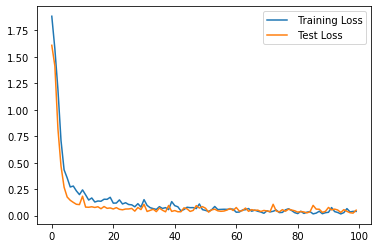

In [67]:
plt.plot(history.history['loss'], label = ' Training Loss')
plt.plot(history.history['val_loss'], label = ' Test Loss')
plt.legend()

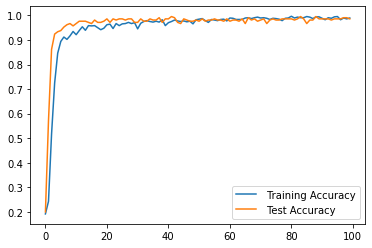

In [68]:
plt.plot(history.history['accuracy'], label = ' Training Accuracy')
plt.plot(history.history['val_accuracy'], label = ' Test Accuracy')
plt.legend()

In [69]:
# print evaluation scores

model_5_eval = model_5.evaluate(X_test_5, y_test_cnn, verbose=1)
model_5_metrics = model_5.metrics_names

print(f"Model 5 {model_5_metrics[0]}: {model_5_eval[0]}")
print(f"Model 5 {model_5_metrics[1]}: {model_5_eval[1]}")

210/210 [==============================] - 0s 2ms/step
Model 5 loss: 0.05149683413051424
Model 5 accuracy: 0.9857142567634583


**Model 6: Recurrent Neural Network (Long-Short Term Memory LSTM)**

- Features: timesteps and MFCC, padded
- input shape: (42,40)

In [70]:
X = np.array(train_df['mfcc_pad'].tolist())

In [71]:
X_train_6, X_test_6, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [72]:
model_6 = Sequential()

# add masking layer so that it would not use the zeroes
model_6.add(Masking(mask_value=0, input_shape=(42, 40)))

# two LSTM layers
model_6.add(LSTM(64, input_shape = (42,40), return_sequences=True))
model_6.add(LSTM(64, return_sequences=False))

# one dense layer
model_6.add(Dense(64, activation = 'relu'))
model_6.add(Dropout(0.3))

# output layer
model_6.add(Dense(5, activation = 'softmax'))

In [73]:
model_6.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [74]:
model_6.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 42, 40)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 42, 64)            26880     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 325       
Total params: 64,389
Trainable params: 64,389
Non-trainable params: 0
__________________________________________________

In [75]:
%%time

# set random seed
np.random.seed(42)

random.set_seed(42)

history = model_6.fit(X_train_6,
                    y_train,
                    batch_size=32,
                    validation_data=(X_test_6, y_test),
                    epochs=100,
                    verbose=2)

Train on 839 samples, validate on 210 samples
Epoch 1/100
 - 3s - loss: 1.4884 - accuracy: 0.3731 - val_loss: 1.2554 - val_accuracy: 0.6000
Epoch 2/100
 - 2s - loss: 1.0001 - accuracy: 0.6603 - val_loss: 0.6543 - val_accuracy: 0.7571
Epoch 3/100
 - 2s - loss: 0.5214 - accuracy: 0.8248 - val_loss: 0.3298 - val_accuracy: 0.8810
Epoch 4/100
 - 2s - loss: 0.2669 - accuracy: 0.9213 - val_loss: 0.2531 - val_accuracy: 0.9048
Epoch 5/100
 - 2s - loss: 0.1991 - accuracy: 0.9392 - val_loss: 0.2343 - val_accuracy: 0.9286
Epoch 6/100
 - 2s - loss: 0.1814 - accuracy: 0.9487 - val_loss: 0.1273 - val_accuracy: 0.9667
Epoch 7/100
 - 2s - loss: 0.0985 - accuracy: 0.9726 - val_loss: 0.1870 - val_accuracy: 0.9476
Epoch 8/100
 - 2s - loss: 0.1248 - accuracy: 0.9631 - val_loss: 0.1769 - val_accuracy: 0.9476
Epoch 9/100
 - 2s - loss: 0.0446 - accuracy: 0.9893 - val_loss: 0.1285 - val_accuracy: 0.9619
Epoch 10/100
 - 2s - loss: 0.0492 - accuracy: 0.9857 - val_loss: 0.1895 - val_accuracy: 0.9524
Epoch 11/100


Epoch 85/100
 - 2s - loss: 1.0451e-04 - accuracy: 1.0000 - val_loss: 0.2537 - val_accuracy: 0.9571
Epoch 86/100
 - 2s - loss: 1.2733e-04 - accuracy: 1.0000 - val_loss: 0.2548 - val_accuracy: 0.9571
Epoch 87/100
 - 2s - loss: 1.3803e-04 - accuracy: 1.0000 - val_loss: 0.2516 - val_accuracy: 0.9571
Epoch 88/100
 - 2s - loss: 1.3472e-04 - accuracy: 1.0000 - val_loss: 0.2488 - val_accuracy: 0.9524
Epoch 89/100
 - 2s - loss: 2.2312e-04 - accuracy: 1.0000 - val_loss: 0.2493 - val_accuracy: 0.9524
Epoch 90/100
 - 2s - loss: 2.8882e-04 - accuracy: 1.0000 - val_loss: 0.2504 - val_accuracy: 0.9619
Epoch 91/100
 - 2s - loss: 1.1402e-04 - accuracy: 1.0000 - val_loss: 0.2460 - val_accuracy: 0.9619
Epoch 92/100
 - 2s - loss: 1.2272e-04 - accuracy: 1.0000 - val_loss: 0.2412 - val_accuracy: 0.9667
Epoch 93/100
 - 2s - loss: 1.1298e-04 - accuracy: 1.0000 - val_loss: 0.2516 - val_accuracy: 0.9667
Epoch 94/100
 - 2s - loss: 8.9152e-05 - accuracy: 1.0000 - val_loss: 0.2516 - val_accuracy: 0.9667
Epoch 95/1

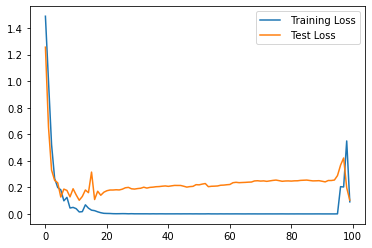

In [76]:
plt.plot(history.history['loss'], label = ' Training Loss')
plt.plot(history.history['val_loss'], label = ' Test Loss')
plt.legend()

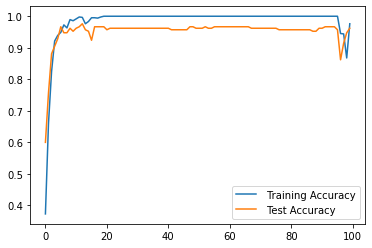

In [77]:
plt.plot(history.history['accuracy'], label = ' Training Accuracy')
plt.plot(history.history['val_accuracy'], label = ' Test Accuracy')
plt.legend()

In [78]:
# print evaluation scores

model_6_eval = model_6.evaluate(X_test_6,y_test, verbose=1)
model_6_metrics = model_6.metrics_names

print(f"Model 6 {model_6_metrics[0]}: {model_6_eval[0]}")
print(f"Model 6 {model_6_metrics[1]}: {model_6_eval[1]}")

210/210 [==============================] - 0s 696us/step
Model 6 loss: 0.10365813679638364
Model 6 accuracy: 0.961904764175415


**Model 7: Recurrent Neural Network (Gated Recurrent Units GRU)**

- Features: timesteps and MFCC, padded
- input shape: (42,40)

In [79]:
# it uses the same train test split as above
X_train_7, X_test_7, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [80]:
model_7 = Sequential()

# add masking layer so that it would not use the zeroes
model_7.add(Masking(mask_value=0, input_shape=(42, 40)))

# two GRU layers
model_7.add(GRU(64, input_shape = (42,40), return_sequences=True))
model_7.add(GRU(64, return_sequences=False ))

# one dense layer
model_7.add(Dense(64, activation = 'relu'))
model_7.add(Dropout(0.5))

# output layer
model_7.add(Dense(5, activation = 'softmax'))

In [81]:
model_7.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [82]:
model_7.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, 42, 40)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 42, 64)            20160     
_________________________________________________________________
gru_2 (GRU)                  (None, 64)                24768     
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 5)                 325       
Total params: 49,413
Trainable params: 49,413
Non-trainable params: 0
__________________________________________________

In [83]:
%%time

# set random seed
np.random.seed(42)

random.set_seed(42)

history = model_7.fit(X_train_7,
                    y_train,
                    batch_size=32,
                    validation_data=(X_test_7, y_test),
                    epochs=100,
                    verbose=2)

Train on 839 samples, validate on 210 samples
Epoch 1/100
 - 3s - loss: 1.3740 - accuracy: 0.4243 - val_loss: 0.9876 - val_accuracy: 0.7000
Epoch 2/100
 - 2s - loss: 0.8961 - accuracy: 0.6520 - val_loss: 0.6076 - val_accuracy: 0.8286
Epoch 3/100
 - 2s - loss: 0.6039 - accuracy: 0.7902 - val_loss: 0.3802 - val_accuracy: 0.9048
Epoch 4/100
 - 2s - loss: 0.3379 - accuracy: 0.9058 - val_loss: 0.2666 - val_accuracy: 0.9143
Epoch 5/100
 - 2s - loss: 0.2136 - accuracy: 0.9476 - val_loss: 0.2172 - val_accuracy: 0.9381
Epoch 6/100
 - 2s - loss: 0.1373 - accuracy: 0.9631 - val_loss: 0.1910 - val_accuracy: 0.9476
Epoch 7/100
 - 2s - loss: 0.1560 - accuracy: 0.9535 - val_loss: 0.2384 - val_accuracy: 0.9238
Epoch 8/100
 - 2s - loss: 0.1013 - accuracy: 0.9738 - val_loss: 0.2366 - val_accuracy: 0.9143
Epoch 9/100
 - 2s - loss: 0.0664 - accuracy: 0.9845 - val_loss: 0.2707 - val_accuracy: 0.9286
Epoch 10/100
 - 2s - loss: 0.0670 - accuracy: 0.9833 - val_loss: 0.2539 - val_accuracy: 0.9333
Epoch 11/100


Epoch 87/100
 - 2s - loss: 4.8480e-04 - accuracy: 1.0000 - val_loss: 0.5131 - val_accuracy: 0.9429
Epoch 88/100
 - 2s - loss: 3.2459e-04 - accuracy: 1.0000 - val_loss: 0.5176 - val_accuracy: 0.9429
Epoch 89/100
 - 2s - loss: 4.8926e-04 - accuracy: 1.0000 - val_loss: 0.5339 - val_accuracy: 0.9429
Epoch 90/100
 - 2s - loss: 3.3867e-04 - accuracy: 1.0000 - val_loss: 0.5301 - val_accuracy: 0.9429
Epoch 91/100
 - 2s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.5165 - val_accuracy: 0.9429
Epoch 92/100
 - 2s - loss: 6.9582e-04 - accuracy: 1.0000 - val_loss: 0.4948 - val_accuracy: 0.9429
Epoch 93/100
 - 2s - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.4913 - val_accuracy: 0.9429
Epoch 94/100
 - 2s - loss: 5.0792e-04 - accuracy: 1.0000 - val_loss: 0.4898 - val_accuracy: 0.9429
Epoch 95/100
 - 2s - loss: 8.5302e-04 - accuracy: 1.0000 - val_loss: 0.4982 - val_accuracy: 0.9429
Epoch 96/100
 - 2s - loss: 5.8290e-04 - accuracy: 1.0000 - val_loss: 0.4823 - val_accuracy: 0.9476
Epoch 97/100
 - 2s

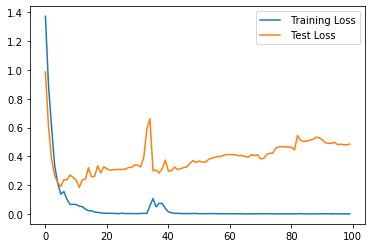

In [84]:
plt.plot(history.history['loss'], label = ' Training Loss')
plt.plot(history.history['val_loss'], label = ' Test Loss')
plt.legend()

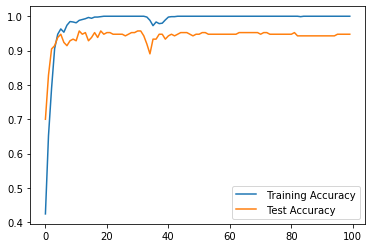

In [85]:
plt.plot(history.history['accuracy'], label = ' Training Accuracy')
plt.plot(history.history['val_accuracy'], label = ' Test Accuracy')
plt.legend()

In [86]:
# print evaluation scores

model_7_eval = model_7.evaluate(X_test_7, y_test, verbose=1)
model_7_metrics = model_7.metrics_names

print(f"Model 7 {model_7_metrics[0]}: {model_7_eval[0]}")
print(f"Model 7 {model_7_metrics[1]}: {model_7_eval[1]}")

210/210 [==============================] - 0s 500us/step
Model 7 loss: 0.4855939027574745
Model 7 accuracy: 0.9476190209388733


## 5. Evaluation

After the models are trained, they will be evaluated and the best model will be chosen. The best performing model will be chosen based on the best accuracy score. The top 2 models will also be tested against unseen data.

### Summary Table

In [87]:
eval_df = pd.DataFrame(columns=['Model', 'Type', 'Accuracy', 'Loss'])

In [88]:
eval_df['Model'] = ['Model 1 (baseline)', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6', 'Model 7']
eval_df['Type'] = ['FNN', 'FNN', 'FNN', 'CNN', 'CNN', 'RNN (LSTM)', 'RNN (GRU)']
eval_df['Accuracy'] = [model_1_eval[1], model_2_eval[1], model_3_eval[1], model_4_eval[1], model_5_eval[1],
                      model_6_eval[1], model_7_eval[1]]

eval_df['Loss'] = [model_1_eval[0], model_2_eval[0], model_3_eval[0], model_4_eval[0], model_5_eval[0],
                      model_6_eval[0], model_7_eval[0]]

eval_df.sort_values(by='Accuracy', ascending = False)

,Model,Type,Accuracy,Loss
4,Model 5,CNN,0.985714,0.051497
5,Model 6,RNN (LSTM),0.961905,0.103658
2,Model 3,FNN,0.957143,0.183858
6,Model 7,RNN (GRU),0.947619,0.485594
1,Model 2,FNN,0.942857,0.118335
3,Model 4,CNN,0.909524,0.604536
0,Model 1 (baseline),FNN,0.695238,1.280541


Based on the results, the top 2 performing models are the CNN model with data processed by images and the RNN model with Long-Short Term Memory (LSTM) layers. They have an accuracy of 98.57% and 96.19%.

To further assess their accuracy, we can examine the classification report.

Before that, the labels will be converted so that they can be compared with the predictions.

In [89]:
# create labels for test set
labels = list(le.classes_)

y_test_labels = []
for pred in y_test:
    for n, i in enumerate(pred):
        if i == 1:
            y_test_labels.append(labels[n])

In [90]:
# create labels for test set for cnn
labels = list(le_cnn.classes_)

y_cnn_labels = []
for pred in y_test_cnn:
    for n, i in enumerate(pred):
        if i == 1:
            y_cnn_labels.append(labels[n])

### Classification Report
**Model 1**

In [91]:
# convert predictions to its class labels
y_pred_1 = model_1.predict_classes(X_test_1)
y_pred_1 = list(le.inverse_transform(y_pred_1))

print(classification_report(y_test_labels, y_pred_1))

              precision    recall  f1-score   support

      apples       0.58      0.69      0.63        42
      father       0.67      0.86      0.75        42
     flowers       0.69      0.48      0.56        42
       water       0.80      0.76      0.78        42
      worker       0.78      0.69      0.73        42

    accuracy                           0.70       210
   macro avg       0.70      0.70      0.69       210
weighted avg       0.70      0.70      0.69       210



The accuracy in general is not very good relative to the rest of the model. It is especially bad in predicting `apples` with a precision of 54%. 

**Model 2**

In [92]:
# convert predictions to its class labels
y_pred_2 = model_2.predict_classes(X_test_2)
y_pred_2 = list(le.inverse_transform(y_pred_2))

print(classification_report(y_test_labels, y_pred_2))

              precision    recall  f1-score   support

      apples       0.95      0.98      0.96        42
      father       0.95      0.93      0.94        42
     flowers       0.95      0.93      0.94        42
       water       0.90      0.90      0.90        42
      worker       0.95      0.98      0.96        42

    accuracy                           0.94       210
   macro avg       0.94      0.94      0.94       210
weighted avg       0.94      0.94      0.94       210



Model 2 yields quite consistent results, with an average accuracy of 94%. It is slightly worse in classifying in `water`, with a precision of 90%.

**Model 3**

In [93]:
y_pred_3 = model_3.predict_classes(X_test_3)
y_pred_3 = list(le.inverse_transform(y_pred_3))

print(classification_report(y_test_labels, y_pred_3))

              precision    recall  f1-score   support

      apples       0.98      0.98      0.98        42
      father       0.91      0.98      0.94        42
     flowers       1.00      0.95      0.98        42
       water       0.93      0.95      0.94        42
      worker       0.97      0.93      0.95        42

    accuracy                           0.96       210
   macro avg       0.96      0.96      0.96       210
weighted avg       0.96      0.96      0.96       210



Considering its feature being more complex, this Feedforward Neural Network performs quite well, predicting 100% of `flowers` correctly. However, this model seems to have difficulty classifying `father` accurately. Overall, it gives a 95% score which is higher than previous FNNs.

**Model 4**

In [94]:
y_pred_4 = model_4.predict_classes(X_test_4)
y_pred_4 = list(le.inverse_transform(y_pred_4))

print(classification_report(y_test_labels, y_pred_4))

              precision    recall  f1-score   support

      apples       0.93      0.95      0.94        42
      father       0.90      0.88      0.89        42
     flowers       0.93      0.93      0.93        42
       water       0.86      0.88      0.87        42
      worker       0.93      0.90      0.92        42

    accuracy                           0.91       210
   macro avg       0.91      0.91      0.91       210
weighted avg       0.91      0.91      0.91       210



This CNN model performed quite poorly relative to the other models, giving an overall accuracy of 90%. It is unable to classify any class very well and actually classifies `water` rather poorly, with low accuracy and low recall. Perhaps Spectrogram arrays are not meant to be fed directly into the CNN model.

**Model 5**

In [95]:
y_pred_5 = model_5.predict_classes(X_test_5)
y_pred_5 = list(le_cnn.inverse_transform(y_pred_5))

print(classification_report(y_cnn_labels, y_pred_5))

              precision    recall  f1-score   support

      apples       1.00      1.00      1.00        42
      father       0.95      1.00      0.98        42
     flowers       1.00      0.95      0.98        42
       water       1.00      0.98      0.99        42
      worker       0.98      1.00      0.99        42

    accuracy                           0.99       210
   macro avg       0.99      0.99      0.99       210
weighted avg       0.99      0.99      0.99       210



The CNN model has the best results so far, predicting `apples` and `flowers` with 100% precision. However, it seems like it could have mixed up the sounds between `father`, `water` and `worker` for 1 or 2 speakers. Nonetheless, this impressive model gave an average accuracy score of 98%. 

**Model 6**

In [96]:
y_pred_6 = model_6.predict_classes(X_test_6)
y_pred_6 = list(le.inverse_transform(y_pred_6))

print(classification_report(y_test_labels, y_pred_6))

              precision    recall  f1-score   support

      apples       1.00      0.95      0.98        42
      father       0.93      0.98      0.95        42
     flowers       1.00      0.98      0.99        42
       water       0.91      0.93      0.92        42
      worker       0.98      0.98      0.98        42

    accuracy                           0.96       210
   macro avg       0.96      0.96      0.96       210
weighted avg       0.96      0.96      0.96       210



In general, the Recurrent Neural Networks produce quite consistent results. This model, with LSTM layers, have an accuracy of 96% even though it is slightly weaker in classifying `water`. It has high precision and recall score as well, giving it high overall accuracy.

**Model 7**

In [97]:
y_pred_7 = model_7.predict_classes(X_test_7)
y_pred_7 = list(le.inverse_transform(y_pred_7))

print(classification_report(y_test_labels, y_pred_7))

              precision    recall  f1-score   support

      apples       0.98      0.95      0.96        42
      father       0.95      0.95      0.95        42
     flowers       1.00      0.95      0.98        42
       water       0.93      0.93      0.93        42
      worker       0.89      0.95      0.92        42

    accuracy                           0.95       210
   macro avg       0.95      0.95      0.95       210
weighted avg       0.95      0.95      0.95       210



This RNN with GRU layers also prodcued high precision and recall, giving it an overall accuracy of 94%. It has a balanced result for each class and does not necessarily predict one class much better than other, based on the f1-score.

**Conclusion of Model Results**

Model 5 (CNN Model) and Model 6 (RNN LSTM Model) performed the best, based on accuracy. They also have low validation loss score, which is an added reason to choose the models. They also both performed above the baseline score.

It is not unsurprising that the vanilla feedforward neural network would not perform very well as audio files are too complex to be represented by a one-dimensional matrix.

The top 2 performing model will then be tested on unseen data to determine its ability to generalise.

### Test on Unseen Data

The final round of evaluation will be based on unseen data. As it is not unusual for neural networks to overfit, one good way is to test the models on unseen data and evaluating them again. Furthermore, the ability of the model should also be determined by how well it generalises. Hence, this is an important evaluation to select the final model.

In [98]:
# import test data
test_df = pd.read_csv("./datasets/test.csv")
test_df.head()

,id,filepath,duration,class_label
0,8750049,./assets/audio_test/8750049_father.wav,0.353016,father
1,8750049,./assets/audio_test/8750049_worker.wav,0.531655,worker
2,8750051,./assets/audio_test/8750051_water.wav,0.374467,water
3,8750062,./assets/audio_test/8750062_flowers.wav,0.533379,flowers
4,8750066,./assets/audio_test/8750066_apples.wav,0.503719,apples


**Preprocess for CNN Model (Model 5)**

In [99]:
# generate spectrogram for the test set

# for each file
for n, f in enumerate(test_df['filepath']):
    
    # get unique id
    audio_id = test_df['id'][n]
    
    # get label
    label = test_df['class_label'][n]
    
    # load file
    audio, sr = librosa.load(f)
    
    # plot spectrogram
    plt.figure(figsize=[2,2])
    mel_spec = librosa.feature.melspectrogram(audio, sr=sr, n_mels=20)
    log_mel_spec = librosa.power_to_db(mel_spec)
    librosa.display.specshow(log_mel_spec)
    
    # save and close, slightly padded
    plt.savefig(f"./assets/spec_test/{label}_{audio_id}.png", dpi=500, bbox_inches='tight',pad_inches=0.1)
    plt.close()


In [100]:
# create test data

img_size = 300

# target folder
folder = "./assets/spec_test/"

# create empty list for spectrogram data and label
test_data_spec = []
test_label_spec = []

# get image data and label
for img in os.listdir(folder):
    label, filename = img.split('_')
    path = os.path.join(folder, img)
    im = Image.open(path)
    im = im.convert('RGB')
    im = im.resize((img_size, img_size), Image.ANTIALIAS)
    test_data_spec.append(np.array(im))
    test_label_spec.append(label)


# normalise the data
test_data_spec = np.array(test_data_spec)/255

**Preprocess for RNN (GRU) Model (Model 7)**

In [101]:
# apply function to all files
mfcc_test = test_df['filepath'].map(get_mfcc)

# padding
mfcc_test = pad_sequences(mfcc_test, padding='post', maxlen=42)

# add into the dataframe
test_df['mfcc_pad'] = mfcc_test.tolist()

**Predictions**

CNN Model:

In [102]:
X = test_data_spec

y_test_pred_1 = model_5.predict_classes(X)

In [103]:
y_test_pred_1 = list(le.inverse_transform(y_test_pred_1))

print(classification_report(test_label_spec, y_test_pred_1))

              precision    recall  f1-score   support

      apples       1.00      1.00      1.00        20
      father       0.91      1.00      0.95        20
     flowers       1.00      0.90      0.95        21
       water       0.95      0.95      0.95        20
      worker       0.95      0.95      0.95        20

    accuracy                           0.96       101
   macro avg       0.96      0.96      0.96       101
weighted avg       0.96      0.96      0.96       101



Even on Unseen Data, the CNN Model seems to perform very well, showing its strong ability to generalise well. It manages to perfectly classify `apples`, `father`, and `flowers`, seeming to confuse `water` and `worker`. However, this could also be due to the speaker's poor pronunciation.

RNN Model (GRU):

In [104]:
X = np.array(test_df['mfcc_pad'].tolist())

y_test_pred_2 = model_6.predict_classes(X)

In [105]:
y_test_pred_2 = list(le.inverse_transform(y_test_pred_2))

print(classification_report(test_df['class_label'], y_test_pred_2))

              precision    recall  f1-score   support

      apples       1.00      1.00      1.00        20
      father       0.77      1.00      0.87        20
     flowers       1.00      0.90      0.95        21
       water       0.95      0.90      0.92        20
      worker       0.94      0.80      0.86        20

    accuracy                           0.92       101
   macro avg       0.93      0.92      0.92       101
weighted avg       0.93      0.92      0.92       101



In [106]:
X = np.array(test_df['mfcc_pad'].tolist())

y_test_pred_3 = model_7.predict_classes(X)

In [107]:
y_test_pred_3 = list(le.inverse_transform(y_test_pred_3))

print(classification_report(test_df['class_label'], y_test_pred_3))

              precision    recall  f1-score   support

      apples       1.00      1.00      1.00        20
      father       0.91      1.00      0.95        20
     flowers       1.00      0.95      0.98        21
       water       0.95      0.95      0.95        20
      worker       0.95      0.90      0.92        20

    accuracy                           0.96       101
   macro avg       0.96      0.96      0.96       101
weighted avg       0.96      0.96      0.96       101



On the unseen data, the RNN (LSTM) generalises better than the CNN Model, giving an almost perfect classification. From this table, it can be deduced that it has misclassified one audio, mistaking `father` for `flowers`. 

In [108]:
test_df['y_test_pred'] = y_test_pred_2

## 6. Conclusion and Recommendations